In [1]:
from itertools import product
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from prep_data import \
    mazes,\
    model_preds,\
    get_exp1_at,\
    get_exp2_at,\
    get_exp3_at__exp3_mt,\
    get_exp4a_ht,\
    get_exp4b_ht
from analysisutils import short_predictor_names

In [2]:
predictors = [
    'vgc_weight',
    'log_traj_based_hitcount',
    'graph_based_hitcount',
    # 'nav_mindist',
    # 'nav_mindist_timestep',
    'bottleneck_dist',
    'sr_occ',
    'optpolicy_dist',
    'goal_dist',
    'start_dist',
    'walls_dist',
    'center_dist',
]
plan_exp_data = pd.concat([
    get_exp1_at()[["sessionId", "grid", "obstacle", "attention_N"] + predictors].assign(exp_dv="exp1_attn").rename(columns={"attention_N": "measure"}),
    get_exp2_at()[["sessionId", "grid", "obstacle", "attention_N"] + predictors].assign(exp_dv="exp2_attn").rename(columns={"attention_N": "measure"}),
    get_exp3_at__exp3_mt()[0][["sessionId", "grid", "obstacle", "attention_N"] + predictors].assign(exp_dv="exp3_attn").rename(columns={"attention_N": "measure"}),
    get_exp3_at__exp3_mt()[1][["sessionId", "grid", "obstacle", "correct"] + predictors].assign(exp_dv="exp3_correct").rename(columns={"correct": "measure"}),
    get_exp3_at__exp3_mt()[1][["sessionId", "grid", "obstacle", "conf_N"] + predictors].assign(exp_dv="exp3_conf").rename(columns={"conf_N": "measure"}),
    get_exp4a_ht()[["sessionId", "grid", "obstacle", "hovered"] + predictors].assign(exp_dv="exp4a_hov").rename(columns={"hovered": "measure"}),
    get_exp4a_ht()[["sessionId", "grid", "obstacle", "log_hoverduration"] + predictors].assign(exp_dv="exp4a_dur").rename(columns={"log_hoverduration": "measure"}),
    get_exp4b_ht()[["sessionId", "grid", "obstacle", "hovered"] + predictors].assign(exp_dv="exp4b_hov").rename(columns={"hovered": "measure"}),
    get_exp4b_ht()[["sessionId", "grid", "obstacle", "log_hoverduration"] + predictors].assign(exp_dv="exp4b_dur").rename(columns={"log_hoverduration": "measure"}),
]).reset_index(drop=True)
exp_dv_names = {
    'exp1_attn': "Initial Exp.\nAwareness Judgment",
    'exp2_attn': "Up-front Planning Exp.\nAwareness Judgment",
    'exp3_correct': "Critical Maze Exp.\nRecall Accuracy",
    'exp3_conf': "Critical Mazes Exp.\nRecall Confidence",
    'exp3_attn': "Cricical Mazes Exp.\nAwareness Judgment",
    'exp4a_hov': "Process-Tracing\n(Initial Mazes 0-11)\nHovering",
    'exp4a_dur': "Process-Tracing\n(Initial Mazes 0-11)\nLog-Hover Duration",
    'exp4b_hov': "Process-Tracing\n(Critical Mazes 12-15)\nHovering",
    'exp4b_dur': "Process-Tracing\n(Critical Mazes 12-15)\nLog-Hover Duration",
}
plan_exp_data['vgc_weight'] = plan_exp_data['vgc_weight'].round(4)

Loading Experiment 1 Attention Trials


In [3]:
exp_dvs = [
    'exp1_attn',
    'exp2_attn',
    'exp3_correct',
    'exp3_conf',
    'exp3_attn',
    'exp4a_hov',
    'exp4a_dur',
    'exp4b_hov',
    'exp4b_dur',
]

# Calculate quantile bins for each predictor
mean_preds = plan_exp_data.groupby(['exp_dv', 'grid', 'obstacle']).mean().reset_index()
assert len(mean_preds) == 12*4*7+4*5*5
for pred in predictors:
    mean_preds[pred+'_quantile'] = None
    for exp_dv in exp_dvs:
        if len(mean_preds[pred][mean_preds.exp_dv == exp_dv].unique()) < 4:
            mean_preds.loc[mean_preds.exp_dv == exp_dv, pred+'_quantile'] = \
                mean_preds[pred][mean_preds.exp_dv == exp_dv].rank(method="dense")
        else:
            mean_preds.loc[mean_preds.exp_dv == exp_dv, pred+'_quantile'] = \
                pd.qcut(mean_preds[pred][mean_preds.exp_dv == exp_dv], q=4, labels=False, duplicates='drop')

Quartile-bin plot saved to  ./extended_data/qbin_figure.eps


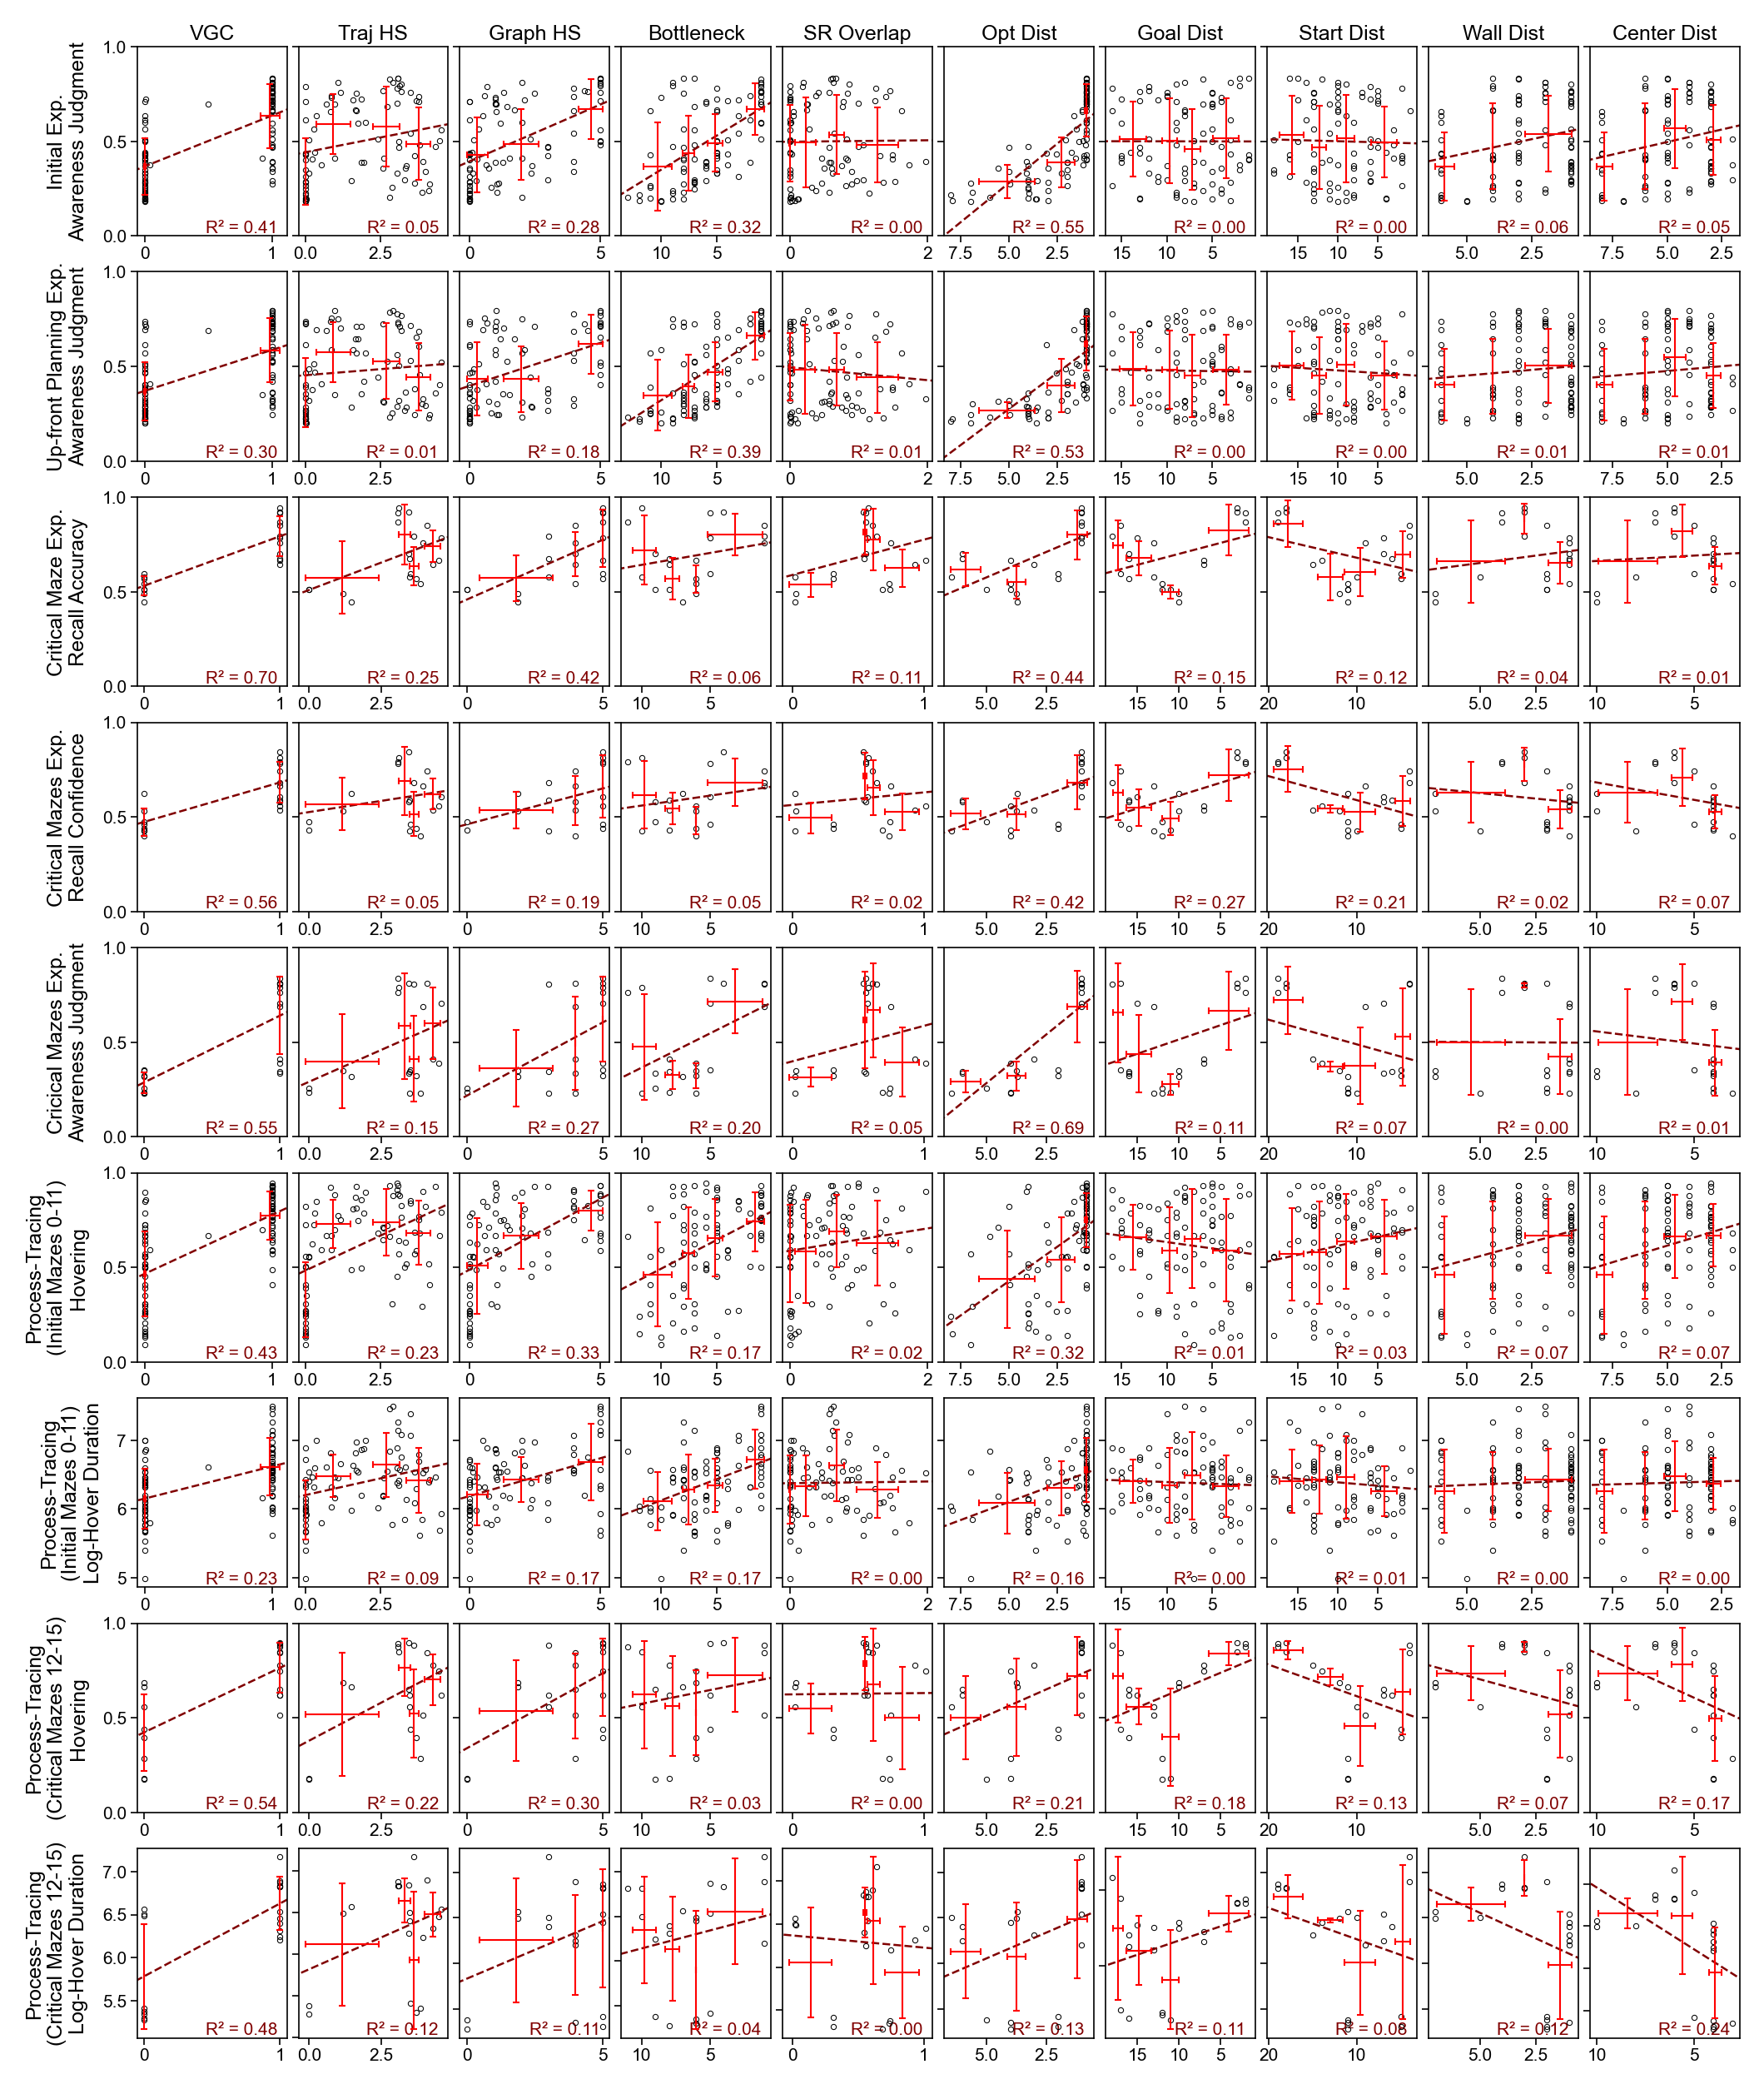

In [7]:
# create figure
fig_width_mm = 182
fig_height_mm = 215
spinewidth=.4

mm_to_inch = 1/25.4 
figsize = (fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch)
assert fig_width_mm <= 182
assert fig_height_mm <= 245

fig, axes = plt.subplots(nrows=len(exp_dvs), ncols=len(predictors), figsize=figsize, dpi=300, facecolor='white')
for exp_dv_i, pred_i in product(range(len(exp_dvs)), range(len(predictors))):
    ax = axes[exp_dv_i][pred_i]
    pred = predictors[pred_i]
    exp_dv = exp_dvs[exp_dv_i]
    for spine in ['top','bottom','left','right']:
        ax.spines[spine].set_linewidth(spinewidth)
        
    # plot individual datapoints
    # to_plot = plan_exp_data[plan_exp_data.exp_dv == exp_dv]
    
    #plot mean by obstacle
    to_plot = plan_exp_data[plan_exp_data.exp_dv == exp_dv].groupby(['grid', 'obstacle', 'exp_dv']).mean().reset_index()
    assert len(to_plot) > 0
    ax.plot(
        to_plot[pred],
        to_plot["measure"],
        'ko',
        zorder=-4,
        markersize=1.5,
        markerfacecolor='none',
        alpha=1.0,
        markeredgewidth=0.25,
        # rasterized=True
    )
    
    # plot quartile bins
    pred_quart_means = mean_preds[mean_preds["exp_dv"] == exp_dv].groupby(pred+'_quantile')[["measure", pred]].mean()
    pred_quart_sem = mean_preds[mean_preds["exp_dv"] == exp_dv].groupby(pred+'_quantile')[["measure", pred]].sem()
    pred_quart_std = mean_preds[mean_preds["exp_dv"] == exp_dv].groupby(pred+'_quantile')[["measure", pred]].std()
    lines = ax.errorbar(
        x=pred_quart_means[pred],
        y=pred_quart_means["measure"],
        # xerr=pred_quart_sem[pred],
        # yerr=pred_quart_sem["measure"],
        xerr=pred_quart_std[pred],
        yerr=pred_quart_std["measure"],
        capsize=1,
        color='red',
        ecolor='red',
        linewidth=0,
        elinewidth=.5,
        capthick=.5,
        linestyle='none',
        zorder=-2,
    )
    ax.tick_params(axis = 'both', which = 'major', labelsize = 5, width=.4, length=2, pad=1)
    if exp_dv_i == 0:
        ax_title = ax.set_title(short_predictor_names.get(pred.replace("_Z", ""), pred), pad=2)
        ax_title.set_fontproperties("Arial")
        ax_title.set_fontsize(6)
    else:
        ax.set_title(None)
    
    if any([_dv in exp_dv for _dv in ["_attn", "_correct", "_conf", "_hov"]]):
    # if any([_dv in exp_dv for _dv in ["_attn", "_conf", "_hov"]]):
        ax.set_ylim(0, 1.0)
        ax.set_yticks([0, .5, 1.0])
    # elif "_dur" in exp_dv:
        # ax.set_ylim(3, 10.2)
        # ax.set_ylim(4, 8.1)
    
    # plot regression line
    # ax.autoscale(False)
    linreg_res = stats.linregress(to_plot[pred], to_plot['measure'])
    # 
    cur_xlim = np.array(ax.get_xlim())
    cur_ylim = np.array(ax.get_ylim())
    ax.plot(
        cur_xlim + np.array([-2, 2]),
        linreg_res.intercept + linreg_res.slope*(cur_xlim + np.array([-2, 2])),
        color='maroon',
        linewidth=.6,
        linestyle='--',
        zorder=-3,
    )
    ax.set_xlim(cur_xlim)
    ax.set_ylim(cur_ylim)
    
    # flip distance-based predictors
    if "dist" in pred:
        cur_xlim = ax.get_xlim()
        ax.set_xlim(cur_xlim[1], cur_xlim[0])
        
    #regression R2    
    r2_text = ax.text(
        ax.get_xlim()[1], ax.get_ylim()[0],
        s=f"R² = {linreg_res.rvalue**2:.2f}  ",
        ha="right",
        va="bottom",
        color='maroon',
        zorder=-5,
        fontfamily="Arial",
        fontsize=5
    )
        
    # format tick labels
    for ax_ticklabel in ax.get_xticklabels():
        ax_ticklabel.set_fontproperties("Arial")
        ax_ticklabel.set_fontsize(5)
        
    if pred_i != 0:
        ax.set_yticklabels([])
        ax.set_ylabel(None)
    else:
        ax_ylabel = ax.set_ylabel(exp_dv_names[exp_dv])
        ax_ylabel.set_fontproperties("Arial")
        ax_ylabel.set_fontsize(6)
        for ax_ticklabel in ax.get_yticklabels():
            ax_ticklabel.set_fontproperties("Arial")
            ax_ticklabel.set_fontsize(5)
            

fig.tight_layout(w_pad=.1, h_pad=.1)
# Open this svg in inkscape and save as eps
# qbin_fig_file = "./results/qbin_figure.svg"
# fig.savefig(
#     qbin_fig_file,
#     dpi=600,
# )
qbin_fig_file = "./extended_data/qbin_figure.eps"
fig.savefig(
    qbin_fig_file,
    dpi=600,
)
print("Quartile-bin plot saved to ", qbin_fig_file)

In [5]:
print("Total number of observations: ", len(plan_exp_data))
print("Total number of participants: ", len(plan_exp_data.sessionId.unique()))

Total number of observations:  84215
Total number of participants:  825
